nodes.shape=(4, 6, 6, 2)


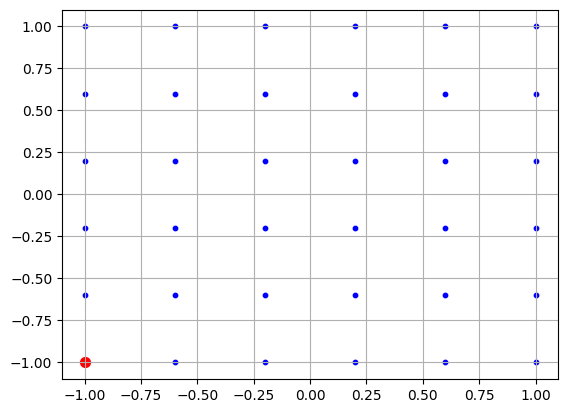

In [17]:
from matplotlib import pyplot as plt
import numpy as np

# Chose number of robots
k = 4
# Chose recharging proportionality constant
q_k = 0.1 # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of nodes in an axis
n = 6
# Create a uniform (n, n, 2) numpy grid for MAXIMUM SPEED
nodes = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
nodes = nodes.reshape(nodes.shape + (1,))
nodes = np.concatenate((nodes[0], nodes[1]), axis=2)
nodes = nodes.reshape((1,) + nodes.shape)
nodes = np.concatenate([nodes for _ in range(k)], axis=0)
print(f"{nodes.shape=}")

# nodes = targets + depots
# Note: If a node isn't a depot, it is a target

## One depot node
depot_indices = np.array([[0, 0]])

target_indices = []
for i in range(n):
    for j in range(n):
        is_depot = False
        for depot in depot_indices:
            if i == depot[0] and j == depot[1]:
                is_depot = True
                continue
        if not is_depot:
            target_indices.append([i,j])
target_indices = np.array(target_indices)
# print(f"{target_indices=}")

# Chose starting depot node
B_k = np.tile(depot_indices, (k, 1))
# B_k = depot_indices[0]
# print(f"{B_k=}")

# Graphical sanity check
plt.figure()
plt.scatter(nodes[0,:,:,0], nodes[0,:,:,1], c='blue', s=10)
plt.scatter(nodes[0,depot_indices[:,0],depot_indices[:,1],0], nodes[0,depot_indices[:,0],depot_indices[:,1], 1], c='red', s=50)
plt.grid()
plt.show()

In [18]:
import itertools

# Calculate c_{i1,j1,i2,j2} (c[i1, j1, i2, j2] is the cost (including recharging, q_k) from TARGET and DEPOT nodes (i1, j1) to (i2, j2))
cost = np.zeros((n,n,n,n))
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    cost[i1,j1,i2,j2] = np.sqrt((nodes[0,i1,j1,0]-nodes[0,i2,j2,0]) ** 2 + (nodes[0,i1,j1,1]-nodes[0,i2,j2,1]) ** 2)
    # print(f"({i1},{j1},{i2},{j2}):({targets[i1,j1,0]},{targets[i1,j1,1]},{targets[i2,j2,0]},{targets[i2,j2,1]}): {target_cost[i1,j1,i2,j2]}")
print(f"{cost.shape=}")

cost.shape=(6, 6, 6, 6)


In [19]:
import gurobipy as gp
from gurobipy import GRB
import itertools

m = gp.Model()

# A. Integer Constraints (4), (5)
x = m.addMVar((k, n, n, n, n), name='x', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))

# Additional Constraints
# _ = m.addConstrs(x[:, :, :, i1, j1].sum() >= 1 for i1, j1 in target_indices)  # visited AT LEAST once
_ = m.addConstrs(gp.quicksum(x[:, :, :, i1, j1]) == 1 for i1, j1 in target_indices) # visited once

# Ensure that for each pair of nodes (i1, j1) and (i2, j2), at most one robot can go from (i1, j1) to (i2, j2)
for i1, j1, i2, j2 in itertools.product(range(n), range(n), range(n), range(n)):
    are_both_depot = any((d1[0] == i1 and d1[1] == j1) and (d2[0] == i2 and d2[1] == j2) for d1 in depot_indices for d2 in depot_indices)
    if not are_both_depot:
        for ki in range(k):
            _ = m.addConstr(gp.quicksum(x[ki, :, :, i2, j2]) <= 1)


In [20]:
# B. Degree Constraints (6), (7), (8), (9), (10)
# (6) and (7) Only one robot arrives and leaves from a target
_ = m.addConstrs(x[:, i1, j1, :, :].sum() == 1 for i1, j1 in target_indices)
_ = m.addConstrs(x[:, :, :, i1, j1].sum() == 1 for i1, j1 in target_indices)

for ki in range(k):
    # (8) and (9) Begin and end at the same position B_k
    _ = m.addConstr(x[ki, B_k[ki, 0], B_k[ki, 1], :, :].sum() <= 1)
    _ = m.addConstr(x[ki, :, :, B_k[ki, 0], B_k[ki, 1]].sum() <= 1)

    # (10) Every robot that visits a target leaves the target
    _ = m.addConstrs((x[ki, :, :, i1, j1] - x[ki, i1, j1, :, :]).sum() == 0 for i1 in range(n) for j1 in range(n))

    # Additional constraint: no loopholes!
    _ = m.addConstrs(x[ki, i, j, i, j] == 0 for i in range(n) for j in range(n))


In [21]:
# C. Capacity and Flow Constraints (11), (12), (13), (14)
p = m.addMVar((k, n, n, n, n), name='p', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))

for ki in range(k):
    # (11) and (12) flow constraints
    right_side = 0
    for i1, j1 in target_indices:
        for i2, j2 in itertools.product(range(n), range(n)):
            right_side += x[ki, i1, j1, i2, j2]
    _ = m.addConstr((p[ki, depot_indices[0, 0], depot_indices[0, 1], :, :] - p[ki, :, :, depot_indices[0, 0], depot_indices[0, 1]]).sum() == right_side)
    _ = m.addConstrs((p[ki, :, :, i1, j1] - p[ki, i1, j1, :, :]).sum() == x[ki, i1, j1, :, :].sum() for i1, j1 in target_indices)

    # (13) Make sure target capacity doesn't change when passing through a depot
    # for i1, j1 in target_indices:
    #     left_side = 0
    #     for i2, j2 in depot_indices:
    #         left_side += p[ki, i2, j2, i1, j1] - p[ki, i1, j1, i2, j2]
    #     _ = m.addConstr(left_side == 0)

    # (14) Ensure that target capacity for each robot doesn't exceed |T|
    _ = m.addConstrs(p[ki, i1, j1, i2, j2] <= len(target_indices) * x[ki, i1, j1, i2, j2] for i1 in range(n) for j1 in range(n) for i2 in range(n) for j2 in range(n))


In [22]:
# D. Fuel Constraints (15), (16), (17), (18), (19), (20)
L = np.sqrt(8) * 2  # Fuel capacity (1 unit of fuel = 1 unit of distance)
M = L + np.sqrt(8)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
r = m.addMVar((k, n, n), name='r', vtype=GRB.CONTINUOUS, lb=0, ub=L)  # (20)

for ki in range(k):
    # (15) and (16)
    _ = m.addConstrs(r[ki, i2, j2] - r[ki, i1, j1] + cost[i1, j1, i2, j2] <= M * (1 - x[ki, i1, j1, i2, j2]) for i1, j1 in target_indices for i2, j2 in target_indices)
    _ = m.addConstrs(r[ki, i2, j2] - r[ki, i1, j1] + cost[i1, j1, i2, j2] >= -M * (1 - x[ki, i1, j1, i2, j2]) for i1, j1 in target_indices for i2, j2 in target_indices)

    # (17) and (18)
    _ = m.addConstrs(r[ki, i2, j2] - L + cost[i1, j1, i2, j2] >= -M * (1 - x[ki, i1, j1, i2, j2]) for i1, j1 in depot_indices for i2, j2 in target_indices)
    _ = m.addConstrs(r[ki, i2, j2] - L + cost[i1, j1, i2, j2] <= M * (1 - x[ki, i1, j1, i2, j2]) for i1, j1 in depot_indices for i2, j2 in target_indices)

    # (19)
    _ = m.addConstrs(r[ki, i1, j1] - cost[i1, j1, i2, j2] >= -M * (1 - x[ki, i2, j2, i1, j1]) for i1, j1 in target_indices for i2, j2 in depot_indices)


In [23]:
# Set objective function (3)
p_max = m.addVar(vtype=GRB.CONTINUOUS, name="p_max")
_ = m.addConstrs((cost * x[ki]).sum() <= p_max for ki in range(k))
m.setObjective(p_max)

# Turn off presolve (default is usually ON, but experiment with this)
m.Params.Presolve = 0

# Set the method for solving LP relaxations
m.Params.Method = 1  # Use the primal simplex method (other options: 0 - auto, 2 - dual simplex)

# Set the barrier crossover parameter (if applicable)
m.Params.Crossover = 0

# Set the number of threads (if your license allows parallel computing)
#m.Params.Threads = <number_of_threads>

# Set the MIP focus to balance optimality and feasibility
m.Params.MIPFocus = 2  # 0 (default) - balanced, 1 - feasible solutions, 2 - proven optimal solutions

# Limit the number of explored nodes (trade-off between speed and optimality)
#m.Params.NodeLimit = <max_number_of_nodes>

# Limit the time Gurobi spends on optimization
#m.Params.TimeLimit = <time_limit_in_seconds>

# Enable heuristics to find good feasible solutions quickly
m.Params.Heuristics = 0.8  # Adjust the parameter based on your preference

# Enable aggressive probing (may help in finding feasible solutions quickly)
m.Params.Cuts = 3  # 0 (default) - automatic, 1 - conservative, 2 - aggressive, 3 - very aggressive

# Use BarHomogeneous algorithm (may be beneficial for certain types of models)
m.Params.BarHomogeneous = 1

# Increase the mip gap tolerance (trade-off between speed and optimality)
#m.Params.MIPGap = <desired_mip_gap>

# Disable solution polishing (may speed up the optimization process)
m.Params.SolutionPolish = 0

def visualize_paths_faster():
    for ki in range(k):
        print(f"Robot #{ki}\n-------")
        print(f"Starting position: {B_k[ki]} -> {[nodes[0, B_k[ki, 0], B_k[ki, 1], 0], nodes[0, B_k[ki, 0], B_k[ki, 1], 1]]}")
        fig = plt.figure()
        fig.suptitle(f"Path for robot #{ki}")
        plt.scatter(nodes[0, :, :, 0], nodes[0, :, :, 1], c='blue', s=10)
        plt.scatter(nodes[0, depot_indices[:, 0], depot_indices[:, 1], 0], nodes[0, depot_indices[:, 0], depot_indices[:, 1], 1], c='red', s=50)
        plt.scatter(nodes[0, B_k[ki, 0], B_k[ki, 1], 0], nodes[0, B_k[ki, 0], B_k[ki, 1], 1], c='red', s=100)

        counter = 0
        max_path_length = len(target_indices)

        prev_node = (B_k[ki][0], B_k[ki][1])
        print(f"{prev_node}", end="")

        while counter < max_path_length:
            curr_node = get_next_node(x, ki, prev_node)
            print(f" -> {curr_node}", end="")

            plt.scatter(nodes[0, curr_node[0], curr_node[1], 0], nodes[0, curr_node[0], curr_node[1], 1], c="purple", s=8)
            plt.plot([nodes[0, prev_node[0], prev_node[1], 0], nodes[0, curr_node[0], curr_node[1], 0]],
                     [nodes[0, prev_node[0], prev_node[1], 1], nodes[0, curr_node[0], curr_node[1], 1]], color="purple", linewidth=1)

            if curr_node == (B_k[ki][0], B_k[ki][1]):
                break
            prev_node = curr_node
            counter += 1

        plt.grid()
        plt.show()

def get_next_node(x, ki, node):
    for i1, j1 in itertools.product(range(n), range(n)):
        if x[ki, node[0], node[1], i1, j1].getAttr('x') > 0.5:
            return i1, j1
    return None

# Optimize until the first optimal solution is found
while True:
    m.optimize()

    # Check if a feasible solution is found
    if m.status == GRB.OPTIMAL:
        print("First optimal solution found.")
        # Add this part according to the names of your decision variables
        x_values = m.getAttr('x', x)
        p_values = m.getAttr('x', p)
        r_values = m.getAttr('x', r)
    
        # Use the values as needed
        try:
            visualize_paths_faster()
        except:
            print("\nCould not find path")
        break
    elif m.status == GRB.INFEASIBLE:
        print("No feasible solution found.")
        break
    elif m.status == GRB.TIME_LIMIT:
        print("Time limit reached. No optimal solution found within the specified time.")
        break

Set parameter Presolve to value 0
Set parameter Method to value 1
Set parameter Crossover to value 0
Set parameter MIPFocus to value 2
Set parameter Heuristics to value 0.8
Set parameter Cuts to value 3
Set parameter BarHomogeneous to value 1
No parameters matching 'SolutionPolish' found
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i9-10900K CPU @ 3.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads
Academic license 2421738 - for non-commercial use only - registered to sd___@wpi.edu
Optimize a model with 48258 rows, 10513 columns and 277364 nonzeros
Model fingerprint: 0x45c65585
Variable types: 145 continuous, 10368 integer (0 binary)
Coefficient statistics:
  Matrix range     [4e-01, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [6e+00, 4e+01]
  RHS range        [1e+00, 1e+01]
Variable types: 145 continuous, 10368 integer (0 binary)

Explored 0 nodes (0 simplex it